## Load Library

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from Cython.Compiler.Naming import args_cname
from tensorboard.compat.tensorflow_stub.dtypes import float32
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Dict, Any, Optional
from dataclasses import dataclass
import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torch.optim as optim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data loading

In [22]:
def load_dataset(file_path, val_ratio=0.2, random_state=42):
    dataset = np.load(file_path)
    Xtr, Str = dataset['Xtr'], dataset['Str']
    Xts, Yts = dataset['Xts'], dataset['Yts']

    # Shuffle & split (80% train, 20% validation)
    np.random.seed(random_state)
    indices = np.arange(len(Str))
    np.random.shuffle(indices)

    split_idx = int(len(Str) * (1 - val_ratio))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    X_train, y_train = Xtr[train_idx], Str[train_idx]
    X_val, y_val = Xtr[val_idx], Str[val_idx]

    return X_train, y_train, X_val, y_val, Xts, Yts

def reshape_mnist(*arrays):
    reshaped = []

    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = arr.reshape(-1, 1, 28, 28)
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            mean = torch.tensor(0.1307, dtype=torch.float32).view(1, 1, 1)
            std  = torch.tensor(0.3081, dtype=torch.float32).view(1, 1, 1)
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)

def reshape_cifar(*arrays):
    reshaped = []
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = np.transpose(arr, (0, 3, 1, 2))
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)


In [23]:
Xtr_03, Str_03, Xval_03, Sval_03, Xts_03, Yts_03 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.3.npz'))
Xtr_06, Str_06, Xval_06, Sval_06, Xts_06, Yts_06 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.6.npz'))
Xtr_cifar, Str_cifar, Xval_cifar, Sval_cifar, Xts_cifar, Yts_cifar = reshape_cifar(*load_dataset('datasets/CIFAR.npz'))

In [24]:
print("Xtr_03:", Xtr_03.shape)
print("Xtr_06:", Xtr_06.shape)
print("Xtr_cifar:", Xtr_cifar.shape)


Xtr_03: torch.Size([14400, 1, 28, 28])
Xtr_06: torch.Size([14400, 1, 28, 28])
Xtr_cifar: torch.Size([12000, 3, 32, 32])


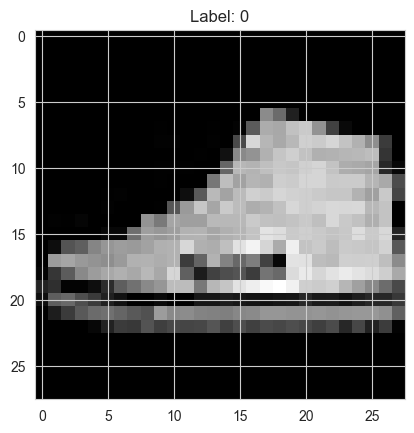

In [25]:
# Mnist data checking
plt.imshow(Xtr_03[114, -1, :, :], cmap='gray') #[pic number,_,_,_]
plt.title(f"Label: {Str_03[0]}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3127563..2.3245049].


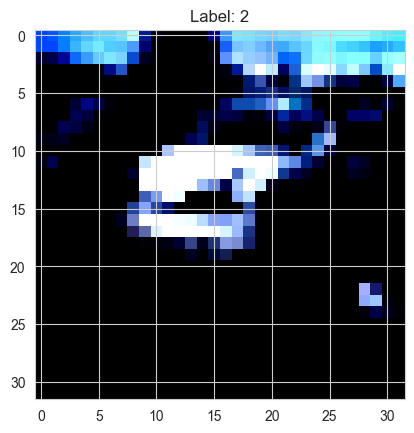

In [26]:
# CIFAR data checking
plt.imshow(np.transpose(Xtr_cifar[514], (1, -1, 0)))
plt.title(f"Label: {Str_cifar[0]}")
plt.show()

4# Main Program

## Classifier: ResNet-34

In [5]:
# ---------------------------
# Config
# ---------------------------
@dataclass
class Config:
    epochs: int = 60
    batch_size: int = 128
    lr: float = 1e-2
    momentum: float = 0.9
    weight_decay: float = 1e-3
    milestones: Tuple[int, int] = (30, 60)
    lam: float = 0.3                 # weight for cycle term
    label_smoothing: float = 0.0
    diag_reg_weight: float = 0.0     # >0 to enforce diagonal-dominance
    diag_margin: float = 0.05
    use_tqdm: bool = True
    tqdm_leave: bool = False
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes,mode='cifar10'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if mode == 'mnist':
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, revision=True):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        clean = F.softmax(out, 1)

        return clean

    def ResNet34(num_classes):
        return ResNet(BasicBlock, [3,4,6,3], num_classes)

In [17]:
# ---------------------------
# transition matrix
# ---------------------------
class sig_t(nn.Module):
    def __init__(self, device, num_classes, init=2):
        super(sig_t, self).__init__()

        self.register_parameter('w', nn.Parameter(-init*torch.ones(C, C, device=device)))

        self.w.to(device)

        co = torch.ones(num_classes, num_classes)
        ind = np.diag_indices(co.shape[0])
        co[ind[0], ind[1]] = torch.zeros(co.shape[0])
        self.co = co.to(device)
        self.identity = torch.eye(num_classes).to(device)


    def forward(self):
        sig = torch.sigmoid(self.w)
        T = self.identity.detach() + sig * self.co.detach()
        T = F.normalize(T, p=1, dim=1)
        return T


In [ ]:
def warmup(train_data, train_loader, model,optimizer_model, loss_func_ce):
    model.train()

    train_loss = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_model.zero_grad()

        clean = model(batch_x)

        ce_loss = loss_func_ce(clean.log(), batch_y.long())
        res = torch.mean(torch.sum(clean.log() * clean, dim=1))
        loss = ce_loss + res

        train_loss += loss.item()

        loss.backward()
        optimizer_model.step()


    print('Warmup Loss: {:.6f}'.format(train_loss / (len(train_data))*args.batch_size))


def train(train_data, train_loader,model,trans_for,trans_back,optimizer_es,optimizer_trans_for,optimizer_trans_back,scheduler1,scheduler2,scheduler3,loss_func_ce):
    model.train()
    trans_for.train()
    trans_back.train()

    train_loss = 0.
    train_acc = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = torch.zeros(batch_x.size(0), args.num_classes).scatter_(1, batch_y.view(-1,1), 1)
        batch_y = batch_y.to(device)

        clean = model(batch_x)
        noise = F.softmax(batch_y, 1)

        t_for = trans_for()
        t_back = trans_back()

        out = torch.mm(clean, t_for)
        out1 = torch.mm(noise, t_back)

        noise_y = torch.max(noise, dim=1)[1].detach()
        clean_y = torch.max(clean, dim=1)[1].detach()
        ce_loss = loss_func_ce(out.log(), noise_y.long())
        ce_loss_1 =  loss_func_ce(out1.log(), clean_y.long())

        for_back_1 = torch.mm(clean, t_for.detach())
        for_back = torch.mm(for_back_1, t_back.detach())

        loss_for_back = loss_func_ce(for_back.log(), clean_y.long())  #loss_func_ce(for_back.log(), clean_y.long()) #-torch.mean(torch.sum(for_back.log() * clean,dim=1)) #


        loss = ce_loss  + ce_loss_1+ args.lam * loss_for_back

        train_loss += loss.item()

        pred = torch.max(out, 1)[1]
        train_correct = (pred == noise_y).sum()
        train_acc += train_correct.item()

        optimizer_es.zero_grad()
        optimizer_trans_for.zero_grad()
        optimizer_trans_back.zero_grad()

        loss.backward()

        optimizer_es.step()
        optimizer_trans_for.step()
        optimizer_trans_back.step()

    print('Train Loss: {:.6f},  Acc: {:.6f}'.format(train_loss / (len(train_data))*args.batch_size,  train_acc / (len(train_data))))

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()


def val(val_data, val_loader, model, trans, loss_func_ce):
    val_acc = 0.
    val_loss = 0.

    with torch.no_grad():
        model.eval()
        trans.eval()

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)
            t = trans()

            out = torch.mm(clean, t)
            loss = loss_func_ce(out.log(), batch_y.long())
            val_loss += loss.item()
            pred = torch.max(out, 1)[1]
            val_correct = (pred == batch_y).sum()
            val_acc += val_correct.item()


    print('Val Loss: {:.6f}, Acc: {:.6f}'.format(val_loss / (len(val_data))*args.batch_size, val_acc / (len(val_data))))

def test(test_data, test_loader, model):
    eval_loss = 0.
    eval_acc = 0.

    with torch.no_grad():
        model.eval()

        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)

            loss = loss_func_ce(clean.log(), batch_y.long())
            eval_loss += loss.item()
            pred = torch.max(clean, 1)[1]
            eval_correct = (pred == batch_y).sum()
            eval_acc += eval_correct.item()

        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(test_data)) * args.batch_size,
                                                      eval_acc / (len(test_data))))
    return eval_acc / (len(test_data))


In [ ]:
def main(train_data, val_data, test_data,args):
    #init
    print(args)
    #log = open('./save/T2/{}/{}_{}_{}.txt'.format(args.dataset, args.noise_type, args.noise_rate,args.nums),'w')
    criterion = torch.nn.NLLLoss(reduction="mean")
    if args.dataset == 'mnist':

        args.n_epoch = 60
        num_classes = 10
        milestones = None

        model = ResNet34()
        trans = sig_t(device, args.num_classes)
        trans_1 = sig_t(device, args.num_classes)
        optimizer_trans = optim.Adam(trans.parameters(), lr=args.lr, weight_decay=0)
        optimizer_trans_1 = optim.SGD(trans_1.parameters(), lr=args.lr, weight_decay=0, momentum=0.9)

        t_true = train_data.t
        print('Translate matrix:', file=log, flush=True)
        print(t_true, file=log, flush=True)

    if args.dataset == 'cifar10':

        args.num_classes = 10
        args.n_epoch = 60
        milestones = [30,45]
        model = ResNet34(args.num_classes)
        trans = sig_t(device, args.num_classes)
        trans_1 = sig_t(device, args.num_classes)
        optimizer_trans = optim.SGD(trans.parameters(), lr=args.lr, weight_decay=0, momentum=0.9)
        optimizer_trans_1 = optim.SGD(trans_1.parameters(), lr=args.lr, weight_decay=0, momentum=0.9)


    #optimizer and StepLR
    optimizer_es = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=0.9)
    scheduler1 = MultiStepLR(optimizer_es, milestones=milestones, gamma=0.1)
    scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)
    scheduler3 = MultiStepLR(optimizer_trans_1, milestones=milestones, gamma=0.1)


    #data_loader
    train_loader = DataLoader(dataset=train_data,
                              batch_size=args.batch_size,
                              shuffle=True,
                              num_workers=4,
                              drop_last=False)

    val_loader = DataLoader(dataset=val_data,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=4,
                            drop_last=False)

    test_loader = DataLoader(dataset=test_data,
                             batch_size=args.batch_size,
                             num_workers=4,
                             drop_last=False)

    #cuda
    if torch.cuda.is_available:
        model = model.to(device)
        trans = trans.to(device)
        trans_1 = trans_1.to(device)

    best_acc = 0
    best_acc_back = 0
    #warmup
    for epoch in range(args.warmup_epoch):
        print('epoch[{}], Warmup'.format(epoch + 1))
        warmup(train_data, train_loader, model,optimizer_es, scheduler1)
        val(val_data, val_loader, model, trans)
        acc = test(test_data, test_loader, model)
        if acc> best_acc:
            best_acc = acc
        print('Best_acc: {:.6f}'.format(best_acc))

    acc_list = []
    for epoch in range(args.n_epoch):
        print('epoch[{}], Train'.format(epoch+1))
        train(train_data,train_loader,model,trans,trans_1,optimizer_es,optimizer_trans,optimizer_trans_1,scheduler1,scheduler2,scheduler3)
        val(val_data, val_loader, model, trans)
        acc = test(test_data, test_loader, model)

        acc_list.append(acc)

        if acc> best_acc:
            best_acc = acc


        print('Best_acc: {:.6f}'.format(best_acc))


    print('Best_acc: ', best_acc)
    return best_acc,acc_list


In [ ]:

# =============================================================
# 🔬 Quick Test: ONLY use mnist0.3 tensors already loaded above
#     (append this block at the very bottom of your file)
# =============================================================
if __name__ == "__main__":
    from torch.utils.data import TensorDataset, DataLoader

    # ---- 0) 绑定 tqdm：兼容你当前的 `import tqdm` 顶部导入写法 ----
    try:
        # 如果是 `import tqdm`
        if hasattr(tqdm, "tqdm"):
            tqdm = tqdm.tqdm
    except NameError:
        # 兜底：如果上面没导入成功，就用更智能的 auto 版本
        from tqdm.auto import tqdm  # noqa: F401

    # ---- 1) 选择 mnist0.3 的“已载入张量作为网络输入” ----
    Xtr, Str = Xtr_03, Str_03
    Xva, Sva = Xval_03, Sval_03
    Xte, Yte = Xts_03, Yts_03

    # ---- 2) 基本校验：保证后面训练真的用到你载入的张量 ----


    # ---- 3) 构建 DataLoader（仅使用 mnist0.3 这套）----
    def make_loader(X, y, bs=128, shuffle=False, num_workers=2):
        ds = TensorDataset(X, y)
        return DataLoader(ds, batch_size=bs, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

    batch_size = 128
    train_loader = make_loader(Xtr, Str, bs=batch_size, shuffle=True)
    val_loader   = make_loader(Xva, Sva, bs=batch_size)
    test_loader  = make_loader(Xte, Yte, bs=batch_size)

    # ---- 4) 打印一个 batch，确认网络真实输入的是你载入的张量 ----
    xb_chk, yb_chk = next(iter(train_loader))
    print(f"\nSanity batch -> xb: {tuple(xb_chk.shape)} (min={xb_chk.min():.3f}, max={xb_chk.max():.3f}), "
          f"yb: {tuple(yb_chk.shape)}, labels in [ {int(yb_chk.min())} , {int(yb_chk.max())} ]")

    # ---- 5) 组装配置，跑一个短训练（冒烟测试），确认流程正确 ----
    input_shape = tuple(Xtr.shape[1:])                # (1,28,28)
    num_classes = int(Str.max().item()) + 1

    cfg = Config(
        epochs=60,                 # 先小跑 5 个 epoch 验证流程；确认无误再改回 60
        batch_size=batch_size,
        lr=1e-2,
        momentum=0.9,
        weight_decay=1e-3,
        milestones=(30, 60),
        lam=0.3,
        label_smoothing=0.0,
        diag_reg_weight=0.0,
        diag_margin=0.05,
        use_tqdm=True,
        tqdm_leave=False,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    print(f"\n🚀 Start CCR on MNIST0.3 with your loaded tensors "
          f"(input={input_shape}, classes={num_classes}, device={cfg.device})")
    trainer = CCRTrainer(input_shape, num_classes, cfg)

    # ---- 6) 训练并汇报结果（确保输出与你预期格式一致）----
    result = trainer.fit(train_loader, val_loader, test_loader)


In [22]:
print("\n✅ Test (MNIST0.3) complete.")
print(f"Best Test Accuracy @ Val = {result['best_test_acc']*100:.2f}%")

# 兼容两种返回键
T_key  = "T"      if "T"      in result else "T_for"
Tp_key = "Tp"     if "Tp"     in result else "T_back"

T_est  = result[T_key]
Tp_est = result[Tp_key]

import numpy as np
np.set_printoptions(precision=4, suppress=True)
print("\nForward T (shape:", T_est.shape, ") first 3 cols:\n", T_est[:, :min(3, T_est.shape[1])])
print("\nBackward T' (shape:", Tp_est.shape, ") first 3 cols:\n", Tp_est[:, :min(3, Tp_est.shape[1])])



✅ Test (MNIST0.3) complete.
Best Test Accuracy @ Val = 97.92%

Forward T (shape: (3, 3) ) first 3 cols:
 [[0.756  0.2297 0.0143]
 [0.0205 0.9129 0.0666]
 [0.0375 0.0191 0.9434]]

Backward T' (shape: (3, 3) ) first 3 cols:
 [[0.9424 0.0164 0.0412]
 [0.3008 0.6749 0.0243]
 [0.0288 0.0546 0.9166]]


In [ ]:
T_est